Full fantasy hockey notebook.

Read the associated blog post: https://scibbatical.wordpress.com/2017/05/03/geeking-fantasy-hockey-part-2/

Start by importing the libraries:

In [1]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

I'll create a few lists of headings for plots and charts. These will come in handy later.

In [2]:
names = ['Basement Dwellers','Chotchmahoneless','Dice-n-Draft','Dont Toews Me Bro','Happys Hustlers','Hard Off the Glass','Neals Neat Team','Newfie Rockers','RyansNOTsoRandomTeam','The Gallows Pole', 'TopShelf','Tylers Tilers']
shortnames = ['BDwell','Chotch','D-n-D','Toews','Hustle','HrdGls','NNeatT','Newfie','RnsRT','T G P','TpShlf','Tilers']
cats = ['G', 'A', '+/-', 'Hits', 'Blk', 'W', "SV%"]
recordstats = ['W','L','T','Pts','Cats']

The team's performances for each week are saved as individual .csv files and placed in GitHub. The filenames are w1.csv, w2.csv, w3.csv, etc... Let's define a function to load a week into Python:

In [3]:
def loadweekonline(weeknumber):
    
    # weeknumber is an integer defining the week of the season for which you'd like to load the results
    
    url = 'https://raw.githubusercontent.com/scibbatical/fan_hockey/master/w%s.csv' % weeknumber
    results = np.array(pd.read_csv(url,header=None))
    
    return results


# let's try it out

BHLresults = loadweekonline(5)

print(BHLresults)

[[ 10.      7.      2.     20.     28.      1.      0.862]
 [  6.     10.      3.     23.     14.      3.      0.912]
 [  6.     13.      6.     44.     20.      3.      0.941]
 [  3.      8.      0.     48.     35.      4.      0.946]
 [  5.      5.     -7.     76.     29.      2.      0.92 ]
 [  6.     14.     -5.     27.     24.      1.      0.91 ]
 [  4.      7.     13.     33.     27.      4.      0.917]
 [  4.      6.    -15.     27.     19.      3.      0.934]
 [  4.      8.      2.     41.     40.      3.      0.952]
 [  5.      5.     -5.     28.     29.      2.      0.931]
 [  4.      6.     10.     35.     34.      1.      0.891]
 [  8.     10.      1.     65.     34.      1.      0.905]]


Each row is a team's stats for week 1, and each column is a stat category. This is data represents a team's performance in each of the stat categories. The results of the week's fantasy matchups is not captured, so we don't know who earned points for the league standings.

We can add another dimension to the data: time. Each week will be represented by a layer, where each layer will be a 2D array of results like the one we've already loaded.

Let's define a function that uses **_loadweekonline_** to create our 3D result array, then use it to load 19 weeks of results.

In [4]:
def compresultsonline(uptoweek):  # uptoweek is an integer for pool week
    
    # start by loading the first week    
    results = [loadweekonline(1)]
    
    # now append the other weeks onto results        
    for i in range(uptoweek-1):
        results = np.append(results,[loadweekonline(i+2)],axis=0)
        
    return results

# let's try it out
BHLresults = compresultsonline(19)

# viewing a 19x12x7 array might be a bit much... but let's check its size
BHLresults.shape

(19, 12, 7)

As expected, since we have 19 weeks, 12 teams, and 7 categories.

Data seems to be loaded alright... now let's DO something with this data!

One of the basics is figuring out who would have won a matchup between two teams on a given week. Let's define a function that tallies the number of categories won, lost, and tied given each team's performance as a separate array:

In [5]:
def matcheval(A,B):
    
    # the convention here is that A is the "home team"
    # matcheval(A,B) =! matcheval(B,A)
    
    Acat = 0
    Bcat = 0
    tiecat = 0
    for i in range(7):
        if A[i] > B[i]:
            Acat += 1
        elif A[i] < B[i]:
            Bcat +=1
        else:
            tiecat += 1
    
    # determine points standings points earned by "home team"
    if Acat > Bcat:
        points = 2  # two points for a win
    elif Acat < Bcat:
        points = 0  # zero points for a loss
    else:
        points = 1  # one point for a tie
        
    return [Acat,Bcat,points]

Let's try this out.

First, we'll need some performance data. Let's extract the performance of Basement Dwellers and Happys Hustlers in the 4th week.

In [6]:
bdwell = BHLresults[3,0,:]
hhustle = BHLresults[3,4,:]

# combine the teams' results into a single array
results = np.append([bdwell],[hhustle],axis=0)

# display using pandas
pd.DataFrame(results, index=['Basement Dwellers','Happys Hustlers'], columns=cats)

,G,A,+/-,Hits,Blk,W,SV%
Basement Dwellers,8.0,5.0,-10.0,28.0,28.0,2.0,0.947
Happys Hustlers,5.0,5.0,1.0,79.0,38.0,4.0,0.957


My eyes tell me that the Hustlers did pretty well against those Basement Dwellers, but let's use **_matcheval_**:

In [7]:
matcheval(bdwell,hhustle)

[1, 5, 0]

As the "home team", Basement Dwellers won 1 category, lost 5, and earned 0 points for league standings.

I admit, using this function to evaluate a single matchup is questionable, but knowing where I want to go with this project, I can see the utility.



# The Round Robin

In H2H fantasy sports, you may only be matched against a particular team once all season. If that's the case, how can you know how your team will stack up? Early in the season, it's important to recognize that the league standings are heavily influenced by the quality of a team's matchup competition. Even a month into the season (20% of the matches played), it can be difficult to know if your team is a contender or a pretender. This stems from the fact that you've only tested your lineup against a fraction of the other teams - your sample size is too small.

To address this, I want to know how a team performs against **every** other team **each week**. This dramatically increases the sample size, and allows a full picture of team strength in only a few weeks. Those familiar with tournaments of any kind will know that a _round robin_ is a stage where each team plays all the other teams in the tournament. I'm using the same idea here.

Let's define a function that uses **_matcheval_** to calculate a round robin result given the teams' performance for a week:

In [8]:
def wkrecord(a):
    
    # determine the number of teams
    teams = a.shape[0]
    
    # create an array to populate with results
    output=np.zeros([teams,5],dtype=np.int)
    
    # populate the results
    for i in range(teams):
        for j in range(teams):
            if i != j:
                match = matcheval(a[i],a[j])
                
                # Accumulate the W/L/T
                if match[2] == 2:
                    output[i,0] +=1
                elif match[2] == 1:
                    output[i,2] +=1
                else:
                    output[i,1] +=1
                
                # Accumulate the points                
                output[i,3] += match[2]
                
                # Accumulate the categories
                output[i,4] += match[0]

    return output


# now let's test it to see how teams stacked against each other in the 9th week

results = wkrecord(BHLresults[8,:,:]) # since the index for the first week is 0, the 9th week is 8

pd.DataFrame(results, index=names, columns=['W','L','T','Pts','Cats'])

,W,L,T,Pts,Cats
Basement Dwellers,1,9,1,3,23
Chotchmahoneless,6,4,1,13,40
Dice-n-Draft,3,5,3,9,39
Dont Toews Me Bro,8,2,1,17,44
Happys Hustlers,8,1,2,18,43
Hard Off the Glass,3,7,1,7,28
Neals Neat Team,0,11,0,0,25
Newfie Rockers,5,2,4,14,40
RyansNOTsoRandomTeam,9,1,1,19,47
The Gallows Pole,3,6,2,8,31


These are the results when a team is matched against *all* other teams for the week. My team (The Gallows Pole) didn't do very well that week - I only managed to beat three other teams. I earned eight "round robin" points (two for each win, one for each tie), and won 31 categories along the way.

I was curious to see how teams accumulated these round robin points over the course of a season in a visual way. I wrote a function to plot the series out. It uses **_weekrecord_**:

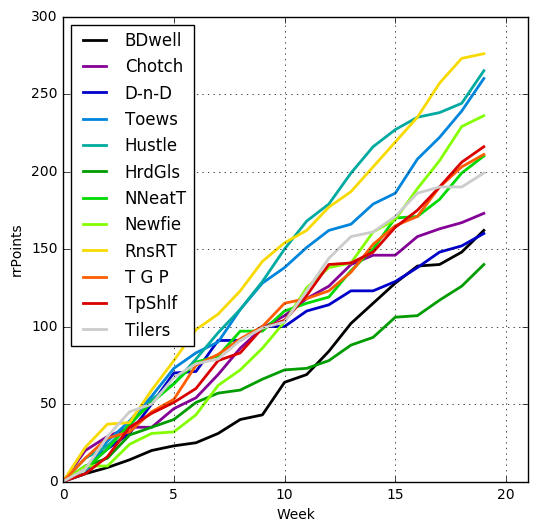

In [9]:
def rrpoints(a):
    
    weeks = len(a)
    nteams = len(a[0])
    
    output = [0*wkrecord(a[0])]
    
    for i in range(weeks):
        output = np.append(output,[output[i]+wkrecord(a[i])],axis=0)
        
    plt.figure(figsize=(6,6))
    
    color_idx = np.linspace(0, 1, nteams)
    
    for team in range(len(names)):
        ax = plt.plot(output[:,team,3],label=shortnames[team],color=plt.cm.spectral(color_idx[team]),lw=2)
        
    plt.xlim(0,21)
    plt.ylim(0,300)
    plt.xlabel('Week')
    plt.ylabel('rrPoints')
    plt.grid(True)
    ax = plt.legend(loc='upper left')
    
    # when I run this script for my own analysis I like to save the plot using:
    #plt.savefig('rraccum.jpeg')
            
    return 


# test it out
rrpoints(BHLresults)

Though not amazingly useful, I like this plot. It gives the round robin points standings a visual representation through time. It seems like a natural application of **_weekrecord_**.

Another natural followup to **_wkrecord_** is a function that calculates the round robin results for _all_ weeks:

In [10]:
def seasonrecord(a):
        
    weeks = len(a)
    
    output = wkrecord(a[0])
    
    for i in range(weeks-1):
        output += wkrecord(a[i+1])

    return output


# test it out to see how the teams have performed so far this season
results = seasonrecord(BHLresults)

rrresults = pd.DataFrame(results, index=names, columns=['W','L','T','Pts','Cats'])

rrresults.sort_values(by='Pts',ascending=0)

,W,L,T,Pts,Cats
RyansNOTsoRandomTeam,126,59,24,276,802
Happys Hustlers,123,67,19,265,761
Dont Toews Me Bro,117,66,26,260,756
Newfie Rockers,105,78,26,236,743
TopShelf,97,90,22,216,685
The Gallows Pole,93,91,25,211,685
Neals Neat Team,94,93,22,210,672
Tylers Tilers,89,99,21,199,663
Chotchmahoneless,75,111,23,173,624
Basement Dwellers,72,119,18,162,610


I sorted the results based on the *Pts*.

I think it's useful to analyze the data to understand how a team matches up against another through the year. Ryan's Team is the best in the league, but is there a team that performs better against Ryan than the others? Why is that? Does Ryan's Team have a weakness??

I'll define another funtion to determine Team A's record against Team B. I'll use **_matcheval_** again.

In [11]:
def avsb(a,b,results):
    
    # like matcheval, the convention here is that A is the "home team"
    # matcheval(A,B) =! matcheval(B,A)
    
    weeks = len(results)
    
    record=[0,0,0]
    
    for i in range(weeks):
        weekres = matcheval(results[i,a],results[i,b])
        if weekres[2] == 2:
            record[0] +=1
        elif weekres[2] == 0:
            record[1] += 1
        else:
            record[2] +=1
    
    return record


# let's try it out. How did The Gallows Pole do against RyansNotSoRandomTeam?
pd.DataFrame(avsb(9,8,BHLresults),index=['W','L','T'],columns=['T G P vs RnsRT']).transpose()

,W,L,T
T G P vs RnsRT,6,10,3


In 19 weeks this season, I managed to get win or tie almost half the time against the best team in the league. Not terrible. I wonder how others managed against the same team?



I find each of these Round Robin analyses valuable, but I want to summarize all of these separate bits into a single output. I'll define a function that uses **_avsb_**, **_cumrecord_**, and **_seasonrecord_**.

In [12]:
def cumrr(a):
            
    result = np.empty([len(a[0]),len(a[0])+3],dtype='|U11') # create an empty text array
    
    cumrecord = seasonrecord(a)
    
    for row in range(len(a[0])):
        for col in range(len(a[0])):
            if row == col:
                result[row,col] = '==='
            else:
                result[row,col] = '%s-%s-%s' % tuple(avsb(row,col,a))
        
        result[row,len(a[0])] = '  %s-%s-%s  ' % tuple(cumrecord[row,0:3])
        
        result[row,len(a[0])+1] = cumrecord[row,3]
        
        result[row,len(a[0])+2] = cumrecord[row,4]

    table = pd.DataFrame(result, index=names, columns=shortnames+['Overall']+recordstats[3:5])
    
    # when I run this script for my own analysis I like to save the table as a csv using:
    # table.to_csv('cumrr.csv')
    
    return table

# now test cumrr
cumrr(BHLresults)

,BDwell,Chotch,D-n-D,Toews,Hustle,HrdGls,NNeatT,Newfie,RnsRT,T G P,TpShlf,Tilers,Overall,Pts,Cats
Basement Dwellers,===,7-11-1,10-7-2,4-14-1,1-14-4,11-6-2,8-9-2,6-12-1,6-13-0,7-10-2,6-13-0,6-10-3,72-119-18,162,610
Chotchmahoneless,11-7-1,===,7-11-1,3-13-3,6-12-1,9-8-2,6-10-3,6-12-1,4-11-4,9-7-3,7-10-2,7-10-2,75-111-23,173,624
Dice-n-Draft,7-10-2,11-7-1,===,4-15-0,5-13-1,8-10-1,8-11-0,6-12-1,4-14-1,9-7-3,5-13-1,7-11-1,74-123-12,160,606
Dont Toews Me Bro,14-4-1,13-3-3,15-4-0,===,9-9-1,13-3-3,9-8-2,6-8-5,6-9-4,10-7-2,11-6-2,11-5-3,117-66-26,260,756
Happys Hustlers,14-1-4,12-6-1,13-5-1,9-9-1,===,13-5-1,10-6-3,9-8-2,10-8-1,13-5-1,10-7-2,10-7-2,123-67-19,265,761
Hard Off the Glass,6-11-2,8-9-2,10-8-1,3-13-3,5-13-1,===,3-13-3,5-11-3,4-14-1,3-12-4,5-13-1,7-11-1,59-128-22,140,561
Neals Neat Team,9-8-2,10-6-3,11-8-0,8-9-2,6-10-3,13-3-3,===,7-9-3,4-12-3,9-9-1,9-9-1,8-10-1,94-93-22,210,672
Newfie Rockers,12-6-1,12-6-1,12-6-1,8-6-5,8-9-2,11-5-3,9-7-3,===,6-10-3,7-10-2,9-7-3,11-6-2,105-78-26,236,743
RyansNOTsoRandomTeam,13-6-0,11-4-4,14-4-1,9-6-4,8-10-1,14-4-1,12-4-3,10-6-3,===,10-6-3,12-4-3,13-5-1,126-59-24,276,802
The Gallows Pole,10-7-2,7-9-3,7-9-3,7-10-2,5-13-1,12-3-4,9-9-1,10-7-2,6-10-3,===,8-8-3,12-6-1,93-91-25,211,685


That's what I'm talking about! Each team has its own row. On that row you can find their record against any other team, their overall record, their total round robin points and the number of categories they've won.

Looking at RyansNOTsoRandomTeam again: his is the best team in the leauge, but it looks like he doesn't match well against the second-best team, Happys Hustlers. If I wanted to build a team to beat the best team in the league, I'd want to understand what it is about Happys Hustlers that gives them the edge against RyansNOTsoRandomTeam.

# A Rating System

I want to be able to quantify a team's performance characteristics. Are they well-rounded? Or do they focus on Goals and Assists? Are their goalies pulling their weight or would they be interested in trading to improve their Wins and SV% categories?

In my previous notebook on fantasy hockey, I showed how I calculated the teams' mean performance in each category. I'll define a function to do the same thing here. Heck, why not calculate the standard deviation at the same time? I think this stuff will come in useful in a rating system.

In [13]:
def meancats(a):
        
    # initialize an array into which we can populate the values
    output = np.zeros(np.shape(a)[-2:])

    for team in range(np.size(a,1)):
        for cat in range(np.size(a,2)):
            output[team,cat]=np.mean(a[:,team,cat])

    return output


# test the means
results = meancats(BHLresults)

pd.DataFrame(results, index=names, columns=cats)

,G,A,+/-,Hits,Blk,W,SV%
Basement Dwellers,6.842105,10.078947,1.157895,43.710526,28.342105,2.131579,0.906789
Chotchmahoneless,8.263158,16.105263,-0.421053,20.894737,22.657895,2.368421,0.920684
Dice-n-Draft,6.473684,14.815789,-0.868421,31.184211,24.789474,2.315789,0.912632
Dont Toews Me Bro,6.078947,13.500000,-0.289474,47.184211,33.342105,2.552632,0.914263
Happys Hustlers,4.631579,7.447368,0.868421,61.210526,36.789474,3.342105,0.919105
Hard Off the Glass,5.842105,11.710526,0.289474,34.131579,26.947368,1.921053,0.915737
Neals Neat Team,5.078947,9.236842,1.078947,48.078947,29.947368,2.605263,0.920737
Newfie Rockers,7.815789,11.184211,3.078947,46.552632,33.263158,2.210526,0.911421
RyansNOTsoRandomTeam,7.947368,13.736842,1.105263,50.763158,33.763158,2.842105,0.910421
The Gallows Pole,7.157895,16.105263,-0.236842,22.631579,24.421053,3.000000,0.927474


I've played plenty of hockey video games in my days, and their standard is to rate team on scale of 100. It seems natural that I do the same here. The best rating will be 100 and the lowest will be 10. All the others will fall in between. A team's rating for a category is defined by that team's mean performance, and the minimum and maximum means of the other teams:

$$rating = [1- \frac{max(mean_{team1,team2,...,team12})-mean_{team}}{max(mean_{team1,team2,...,team12})-min(mean_{team1,team2,...,team12})}]*90+10$$

To be clear, $max(mean_{team1,team2,...,team12})$ is the average performance of whichever team is the best performer in the category of interest.

Equipped with an equation to define a team's category ratings, let's define a funtion that uses **_meancats_**:

,G,A,+/-,Hits,Blk,W,SV%
Basement Dwellers,64.782609,37.355623,41.076233,60.933420,46.201117,41.690141,31.980769
Chotchmahoneless,100.000000,100.000000,16.860987,10.000000,10.000000,53.098592,77.673077
Dice-n-Draft,55.652174,86.595745,10.000000,32.969974,23.575419,50.563380,51.192308
Dont Toews Me Bro,45.869565,72.917933,18.878924,68.687990,78.044693,61.971831,56.557692
Happys Hustlers,10.000000,10.000000,36.636771,100.000000,100.000000,100.000000,72.480769
Hard Off the Glass,40.000000,54.316109,27.757848,39.549608,37.318436,31.549296,61.403846
Neals Neat Team,21.086957,28.601824,39.865471,70.685379,56.424581,64.507042,77.846154
Newfie Rockers,88.913043,48.844985,70.538117,67.278068,77.541899,45.492958,47.211538
RyansNOTsoRandomTeam,92.173913,75.379939,40.269058,76.677546,80.726257,75.915493,43.923077
The Gallows Pole,72.608696,100.000000,19.686099,13.877285,21.229050,83.521127,100.000000


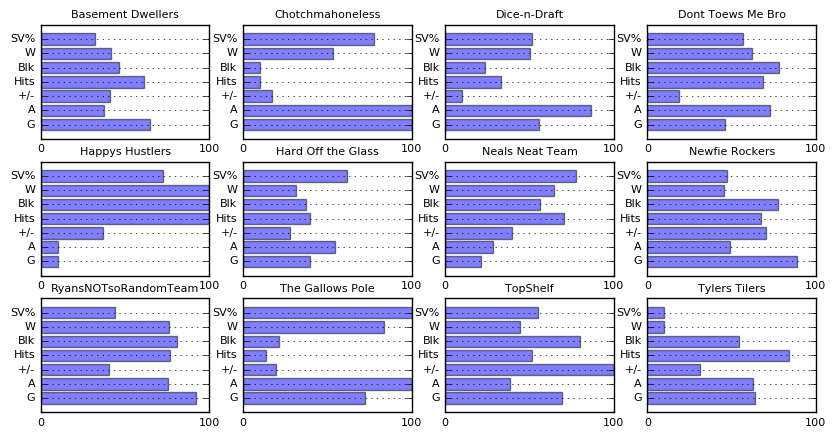

In [16]:
def teamratings(a):
    
    means = meancats(a) # calculate the mean performance in each category
    
    maxm = np.amax(means,axis=0)    # calculate the max of the means
    minm = np.amin(means,axis=0)    # calculate the min of the means
    
    # Calculate the rating
    result = np.add(10,np.multiply(90,np.subtract(1,np.divide(np.subtract(maxm,means),np.subtract(maxm,minm)))))
    
    # Plot a figure
    plt.figure(figsize=(10,5))    
    
    for team in range(len(names)):
        ax = plt.subplot(3,4,team+1)    
        plt.barh(range(len(cats)),result[team],alpha=0.5,align='center')
        plt.xlim(0,100)
        plt.yticks(range(len(cats)),cats,fontsize=8)
        plt.xticks([0,100],[0,100],fontsize=8)
        plt.title(names[team],fontsize=8)
        plt.grid(True)
        
    #plt.savefig('ratings.jpeg')
    
    return result


# test it!
results = teamratings(BHLresults) # automatically plots the results

# show the table of ratings
pd.DataFrame(results, index=names, columns=cats)

I like this. You can see that different managers have different approaches to building teams. Some teams are well-balanced in all categories, while others emphasise some categories over others.

There is a weakness in this approach though... looking at a team's mean performance in a category can be misleading, especially as the season progresses. Early season struggles could mask more recent strength. One _could_ run **_teamratings_** on the most recent subset of the data, then compare to the full dataset:

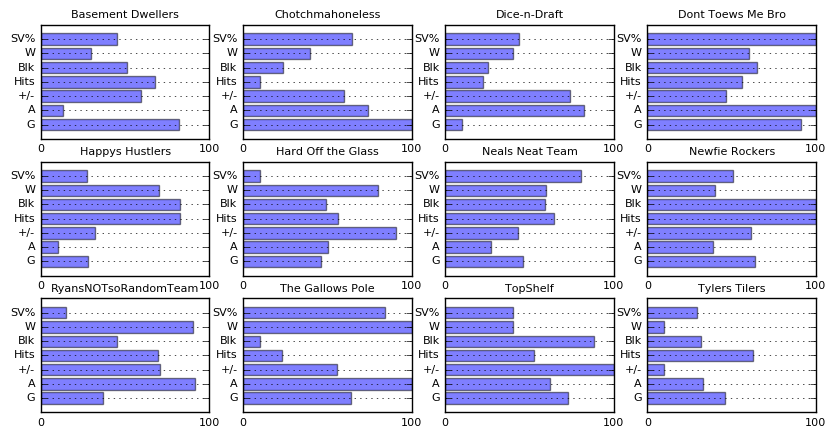

In [17]:
results = teamratings(BHLresults[-3:])

OR.... we could define a function will calculate and plot both at the same time.

Let's define a function that presents the teams' full-season performance ratings with their performance for the past few weeks:

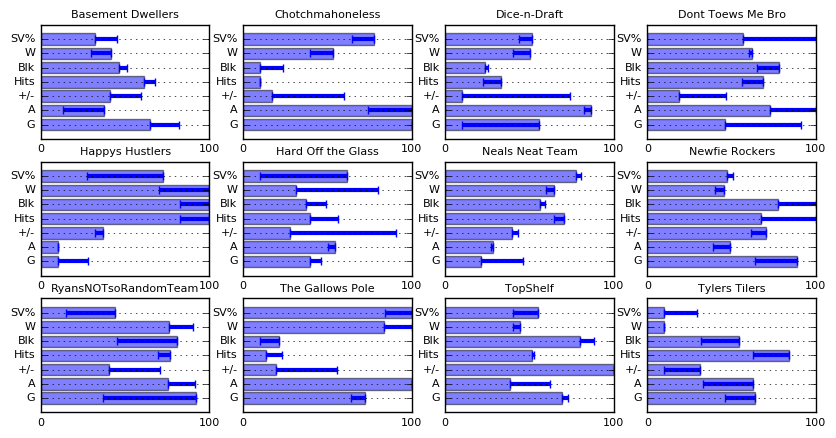

In [18]:
def trendteamratings(a):    
    
    # I'll calculate the LONG-term and SHORT-term performance ratings
    
    meanslong = meancats(a) #start with this.
    
    maxmlong = np.amax(meanslong,axis=0)    # calculate the max of the means
    minmlong = np.amin(meanslong,axis=0)    # calculate the min of the means    
        
    # Calculate the LONG-term rating
    resultlong = np.add(10,np.multiply(90,np.subtract(1,np.divide(np.subtract(maxmlong,meanslong),np.subtract(maxmlong,minmlong)))))
    
    
    meansshort = meancats(a[-3:]) #start with this
    
    maxmshort = np.amax(meansshort,axis=0)    # calculate the max of the means
    minmshort = np.amin(meansshort,axis=0)    # calculate the min of the means    
    
    # Calculate the SHORT-term rating   
    resultshort = np.add(10,np.multiply(90,np.subtract(1,np.divide(np.subtract(maxmshort,meansshort),np.subtract(maxmshort,minmshort)))))    
    
    
    # create error and color arrays for plotting error
    
    errors = np.empty((len(names),len(cats),2))
    
    for team in range(len(names)):
        for cat in range(len(cats)):
            if (resultlong[team,cat]<=resultshort[team,cat]):
                errors[team,cat] = [0,resultshort[team,cat]-resultlong[team,cat]]
            else:
                errors[team,cat] = [resultlong[team,cat]-resultshort[team,cat],0]
    
    # Plot a figure
    plt.figure(figsize=(10,5))    
     
    for team in range(len(names)):
        ax = plt.subplot(3,4,team+1)    
        plt.barh(range(len(cats)),resultlong[team],xerr=np.transpose(errors[team]),error_kw=dict(lw=3, capsize=3, capthick=1),alpha=0.5,align='center')
        plt.xlim(0,100)
        plt.yticks(range(len(cats)),cats,fontsize=8)
        plt.xticks([0,100],[0,100],fontsize=8)
        plt.title(names[team],fontsize=8)
        plt.grid(True)
         
    #plt.savefig('ratingstrend.jpeg')
    
    return


# test it!
results = trendteamratings(BHLresults) # automatically plots the results

These are the ratings for each team's season in light blue, just like **_teamratings_**, along with the teams' most recent performance indicated by the dark blue bar. When that dark blue bar extends to the right of the light blue, it indicates that the recent performance has been better than usual. Dark blue to the left indicates recent performance has been lagging.

This notebook has explained everything needed to produce three charts I find interesting and insightful for my pursuit of fantasy hockey domination. I've written blog posts on www.scibbatical.wordpress.com to explain why I've done so and how they can be used.

,BDwell,Chotch,D-n-D,Toews,Hustle,HrdGls,NNeatT,Newfie,RnsRT,T G P,TpShlf,Tilers,Overall,Pts,Cats
Basement Dwellers,===,7-11-1,10-7-2,4-14-1,1-14-4,11-6-2,8-9-2,6-12-1,6-13-0,7-10-2,6-13-0,6-10-3,72-119-18,162,610
Chotchmahoneless,11-7-1,===,7-11-1,3-13-3,6-12-1,9-8-2,6-10-3,6-12-1,4-11-4,9-7-3,7-10-2,7-10-2,75-111-23,173,624
Dice-n-Draft,7-10-2,11-7-1,===,4-15-0,5-13-1,8-10-1,8-11-0,6-12-1,4-14-1,9-7-3,5-13-1,7-11-1,74-123-12,160,606
Dont Toews Me Bro,14-4-1,13-3-3,15-4-0,===,9-9-1,13-3-3,9-8-2,6-8-5,6-9-4,10-7-2,11-6-2,11-5-3,117-66-26,260,756
Happys Hustlers,14-1-4,12-6-1,13-5-1,9-9-1,===,13-5-1,10-6-3,9-8-2,10-8-1,13-5-1,10-7-2,10-7-2,123-67-19,265,761
Hard Off the Glass,6-11-2,8-9-2,10-8-1,3-13-3,5-13-1,===,3-13-3,5-11-3,4-14-1,3-12-4,5-13-1,7-11-1,59-128-22,140,561
Neals Neat Team,9-8-2,10-6-3,11-8-0,8-9-2,6-10-3,13-3-3,===,7-9-3,4-12-3,9-9-1,9-9-1,8-10-1,94-93-22,210,672
Newfie Rockers,12-6-1,12-6-1,12-6-1,8-6-5,8-9-2,11-5-3,9-7-3,===,6-10-3,7-10-2,9-7-3,11-6-2,105-78-26,236,743
RyansNOTsoRandomTeam,13-6-0,11-4-4,14-4-1,9-6-4,8-10-1,14-4-1,12-4-3,10-6-3,===,10-6-3,12-4-3,13-5-1,126-59-24,276,802
The Gallows Pole,10-7-2,7-9-3,7-9-3,7-10-2,5-13-1,12-3-4,9-9-1,10-7-2,6-10-3,===,8-8-3,12-6-1,93-91-25,211,685


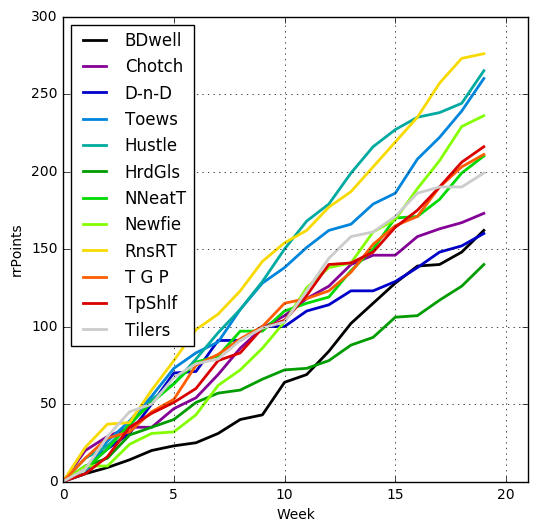

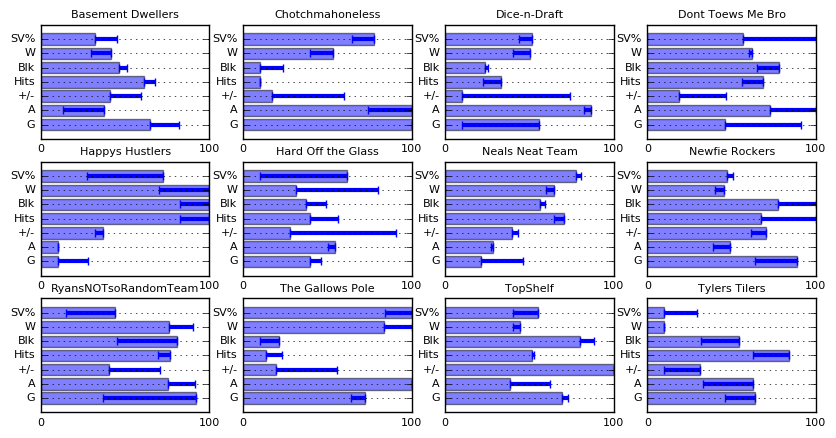

In [19]:
rrpoints(BHLresults)

trendteamratings(BHLresults)

cumrr(BHLresults)